# Downlink Synchronization in 5G Networks: SSB

The tutorial demonstrates the downlink synchronization using synchronization signal block (SSB) in 5G networks. The SSB consists of 4 elements:

- Primary Synchronization Signal (PSS)
- Secondary Synchronization Signal (SSS)
- Physical Broadacast Channel (PBCH) Payload: 432 symbols
- Demodulation Reference Signal (DMRS) for PBCH

The tutorial performs following procedures:

- Import Libraries
    - [Import Python Libraries](#Import-Python-and-SDR-Libraries)
    - [Import 5G Toolkit Libraries](#Import-5G-Toolkit-Libraries)
- [Emulation Configurations](#Emulation-Configurations)
- [Construct SSB](#Generate-the-SSB-Grid-for-synchronization)
    - Generate PSS
    - Generate PSS
    - Generate PBCH
    - Generate DMRS-PBCH
    - Generate SSB
    - [Constellation Diagram](#Constellation-Diagram)
- [OFDM Modulation](#OFDM-Modulation:-Tx)
    - Insert SSB to Tx Resource Grid
    - OFDM Modulation
- [SDR Configuration](#SDR-Setup-Configurations)
- [Transmit using SDR RF Transmitter](#Transmission:-SDR-RF-Transmitter)
- [Receive using SDR RF Receiver](#Reception:-SDR-RF-Receiver)
    - [Receiver Implementation](#Receiver-Implementation)
- [Time Synchronization](#Time-Synchronization:-Based-on-PSS-Correlation)
- [OFDM Receiver and SSB Grid Extraction](#OFDM-Demodulation-and-SSB-Extraction)
    - [Tx-Rx SSB Grid Comparison](#SSB-Grid:-Transmitter-and-Receiver)
    - [Tx-Rx Spectrum Comparison](#Spectrum:-Transmitted-Grid-and-Received-Grid)
- [Frequency Synchronization]()
- [Parameter Estimation](#Parameter-Estimation-for-SSB-and-PBCH)
- [PBCH Estimates](#Channel-Estimation-and-PBCH-Symbol-Equalization)
    - Channel Estimation
    - Equalization
    
- [PBCH Decoding](#PBCH-Decoding-and-Constellation)
    - MIB Decoding
    - ATI Decoding
    
- [BER Computation](#Performance-Verification)


## Import Libraries
### Import Python and SDR Libraries

In [1]:
%matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import numpy as np
import adi


### Import 5G Toolkit Libraries 

In [2]:
from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

## Emulation Configurations

In [3]:
# System Parameters
center_frequency    = 1e9 # Hz

# OFDM Parameters
Bandwidth           = 5*10**6
fftSize             = 256
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols) 

## Transmitter Implementation

![SSB Transmitter](images/PBCH_SDR_Tx.svg)

## Generate the SSB Grid for synchronization


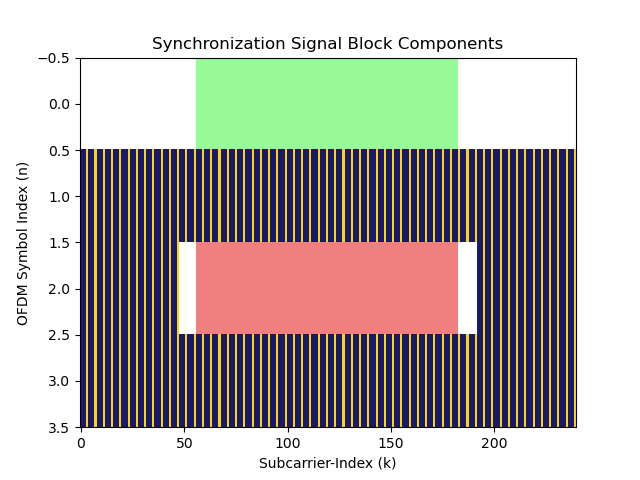

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = 20        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = nRB*12
lengthCP    = (tfParams.lengthCP*(fftSize/tfParams.Nfft)).astype(np.int32)    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, "caseA")

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = subcarrier_spacing
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)

## Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, N_RB=nRB,
                              kssb=0, offsetToPointA = int(nRB*0.5-10),
                              scsCarrier = subCarrierSpacingCommon,
                              ssbPositionInBurst = ssbPositionInBurst, ssbPeriodicity = None, nHF=None,
                              nFrames = 0.1*(subcarrier_spacing/subCarrierSpacingCommon), isPairedBand = isPairedBand,
                              withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid     = ssbRGobject(ssb[0])
fig, ax = ssbObject.displayGrid(option=1)


In [5]:
fig.savefig("SSB.svg", transparent=True, format = "svg")
fig.savefig("SSB.png", transparent=True, format = "png")

## Constellation Diagram

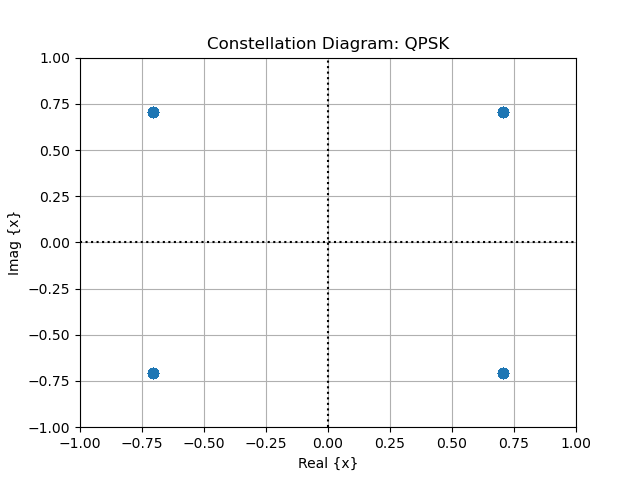

In [6]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.grid()
plt.show()

## OFDM Modulation: Tx

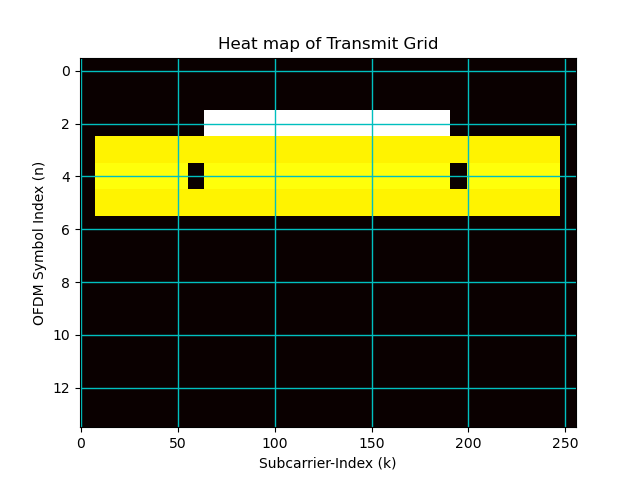

In [7]:
firstSymbolIndex   = int(2)
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

X = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+240] = ssbGrid

#__________________________________________________

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## SDR-Setup Configurations

In [8]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = -10 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0   = 40.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(4*buffer_size)

Exception: No device found

In [ ]:
np.abs(1.3*2**17*(x_time.repeat(1))).max(), np.abs(x_time).min()

## Transmission: SDR RF Transmitter

In [ ]:

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers
sdr.tx(1.3*2**17*(x_time.repeat(1))) # start transmitting


## Receiver Implementation
![Receiver_Implementation](images/PBCH_SDR_Rx.svg)

## Reception: SDR RF Receiver

In [11]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = -20 # Increase to increase tx power, valid range is -90 to 0 dB

# # Config Rx
sdr.gain_control_mode_chan0 = 'slow_attack'
# sdr.rx_hardwaregain_chan0   = 40.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(4*buffer_size)

In [12]:
sdr.tx_destroy_buffer()

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers

# while(True):
sdr.tx(1.2*2**17*(x_time.repeat(1))) # start transmitting

# # # Stop transmitting
# sdr.tx_destroy_buffer()



In [13]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # Stop transmitting
# sdr.tx_destroy_buffer()


## Time Synchronization: Based on PSS Correlation

In [14]:
## PSS Detection: Based on time domain PSS Correlation
# pssPeakIndices, pssCorrelation, rN_ID2 = pssDetection(r, Nfft, lengthCP = lengthCP[1],
#                                                       N_ID2 = None, freqOffset = ssboffset,
#                                                       height = 0.75, prominence = 0.65, width=10)
## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((fftSize-Neff)/2+ssbRGobject.startingSubcarrierIndices)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1],
                                                                  N_ID2 = None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
fig, ax = plt.subplots()

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________

**(rasterOffset, PSS-ID) (8, 0)
**(rasterOffset, PSS-ID) (8, 1)
**(rasterOffset, PSS-ID) (8, 2)
